In [3]:
# flag to modify everything to run better on Colab; change it to true if you want to run on colab
use_colab = False
# use_colab = True


In [2]:
# uncomment for running on colab
!pip install -e .

Obtaining file:///content
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 /usr/local/lib/python3.7/dist-packages/pip/_vendor/pep517/in_process/_in_process.py get_requires_for_build_wheel /tmp/tmpdftlnky7 Check the logs for full command output.


In [39]:
!mkdir './combined/binary_test'
!mkdir './combined/binary_train'

!python3 split_folder.py

copying to train img_44733.jpg 2
copying to train img_72999.jpg 2
copying to train img_25094.jpg 2
copying to train img_69092.jpg 2
copying to train img_92629.jpg 2
copying to train img_3370.jpg 2
copying to train img_67639.jpg 2
copying to train img_58560.jpg 2
copying to train img_35779.jpg 2
copying to train img_10012.jpg 2
copying to train img_70354.jpg 2
copying to train img_54617.jpg 2
copying to train img_26684.jpg 2
copying to train img_82409.jpg 2
copying to train img_5585.jpg 2
copying to train img_19029.jpg 2
copying to train img_40930.jpg 2
copying to train img_31547.jpg 2
copying to train img_87373.jpg 2
copying to train img_10627.jpg 2
copying to train img_66355.jpg 2
copying to train img_97714.jpg 2
copying to train img_37344.jpg 2
copying to train img_54848.jpg 2
copying to train img_59964.jpg 2
copying to train img_70675.jpg 2
copying to train img_43317.jpg 2
copying to train img_13585.jpg 2
copying to train img_63064.jpg 2
copying to train img_91058.jpg 2
copying to t

In [3]:
# mount your Google Drive to access the zip file
from google.colab import drive
drive.mount('/content/drive' )

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/CS_7641_ML_Project/combined.zip

Streaming output truncated to the last 5000 lines.
  inflating: combined/shuffled_train/img_95662.jpg  
  inflating: combined/shuffled_train/img_10146.jpg  
  inflating: combined/shuffled_train/img_51127.jpg  
  inflating: combined/shuffled_train/img_30062.jpg  
  inflating: combined/shuffled_train/img_99370.jpg  
  inflating: combined/shuffled_train/img_26631.jpg  
  inflating: combined/shuffled_train/img_28788.jpg  
  inflating: combined/shuffled_train/img_12232.jpg  
  inflating: combined/shuffled_train/img_33345.jpg  
  inflating: combined/shuffled_train/img_63591.jpg  
  inflating: combined/shuffled_train/img_67377.jpg  
  inflating: combined/shuffled_train/img_90180.jpg  
  inflating: combined/shuffled_train/img_42793.jpg  
  inflating: combined/shuffled_train/img_88416.jpg  
  inflating: combined/shuffled_train/img_86190.jpg  
  inflating: combined/shuffled_train/img_67564.jpg  
  inflating: combined/shuffled_train/img_38773.jpg  
  inflating: combined/shuffled_train/img_47372.j

In [16]:
import os

import torch

from runner import Trainer
from optimizer import get_optimizer
from simple_net import SimpleNet
from simple_net_final import SimpleNetFinal
from my_resnet import MyResNet18
from multilabel_resnet import MultilabelResNet18
from my_optimal_net import OptimalNet
from data_transforms import (
    get_fundamental_transforms,
    get_fundamental_normalization_transforms,
    get_fundamental_augmentation_transforms,
    get_all_transforms,
)
from stats_helper import compute_mean_and_std
from confusion_matrix import (
    generate_confusion_data,
    generate_confusion_matrix,
    plot_confusion_matrix,
    get_pred_images_for_target,
    generate_and_plot_confusion_matrix,
    generate_and_plot_accuracy_table,
)
from dl_utils import save_trained_model_weights

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
is_cuda = True
is_cuda = (
    is_cuda and torch.cuda.is_available()
)  # will turn off cuda if the machine doesnt have a GPU

In [6]:
# CHANGE TO YOUR DIRECTORIES TO COMPUTE MEAN AND STD OF DATASET
data_path = '/media/jer/data2/state-farm-distracted-driver-detection/imgs/train/combined/train/' if not use_colab else "./combined/shuffled_train/"
model_path = "../model_checkpoints/" if not use_colab else "./model_checkpoints/"

In [7]:
# dataset_mean, dataset_std = compute_mean_and_std(data_path)
# dataset_mean, dataset_std = 0.36668006, 0.51483374
dataset_mean, dataset_std = 0.35995296, 0.50824981

In [8]:
inp_size = (224, 224)
# inp_size = (448, 448)

In [17]:
my_resnet = MyResNet18()
print(my_resnet)
print(sum(p.numel() for p in my_resnet.parameters()))

MyResNet18(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [ ]:
optimizer_config = {"optimizer_type": "sgd", "lr": 1e-2, "weight_decay": 1e-5, "momentum": 0.9} # Train Accuracy: 0.7549 Validation Accuracy: 0.3928

In [32]:
my_resnet = MyResNet18()
optimizer = get_optimizer(my_resnet, optimizer_config)

# # loading from colab for confusion matrices
# path = "/home/jer/grad/CV/project-4/src/vision/trained_MyResNet18_final.pt"
# my_resnet.load_state_dict(torch.load(path, map_location=torch.device('cpu')), strict=False)
# my_resnet.load_state_dict(torch.load(path))


trainer = Trainer(
    data_dir=data_path,
    model=my_resnet,
    optimizer=optimizer,
    model_dir=os.path.join(model_path, "resnet18"),
    train_data_transforms=get_all_transforms(inp_size, dataset_mean, dataset_std),
    val_data_transforms=get_fundamental_normalization_transforms(
        inp_size, dataset_mean, dataset_std),
    batch_size=32,
    load_from_disk=False,
    cuda=is_cuda,
)

AttributeError: 'ImageLoader' object has no attribute 'df'

In [ ]:
%%time
# trainer.run_training_loop(num_epochs=25)
trainer.run_training_loop(num_epochs=10)

# trainer.validate()

Epoch:1 Train Loss:0.3160 Val Loss: 1.0936 Train Accuracy: 0.8971 Validation Accuracy: 0.7012
Epoch:2 Train Loss:0.0473 Val Loss: 1.3050 Train Accuracy: 0.9857 Validation Accuracy: 0.6429
Epoch:3 Train Loss:0.0225 Val Loss: 1.2946 Train Accuracy: 0.9940 Validation Accuracy: 0.6373
Epoch:4 Train Loss:0.0158 Val Loss: 1.1630 Train Accuracy: 0.9949 Validation Accuracy: 0.6683
Epoch:5 Train Loss:0.0114 Val Loss: 1.7097 Train Accuracy: 0.9969 Validation Accuracy: 0.6098
Epoch:6 Train Loss:0.0098 Val Loss: 1.7929 Train Accuracy: 0.9974 Validation Accuracy: 0.6087
Epoch:7 Train Loss:0.0095 Val Loss: 1.6318 Train Accuracy: 0.9975 Validation Accuracy: 0.6050
Epoch:8 Train Loss:0.0059 Val Loss: 1.7118 Train Accuracy: 0.9983 Validation Accuracy: 0.6087
Epoch:9 Train Loss:0.0078 Val Loss: 1.4260 Train Accuracy: 0.9974 Validation Accuracy: 0.6500
Epoch:10 Train Loss:0.0070 Val Loss: 1.5534 Train Accuracy: 0.9982 Validation Accuracy: 0.6397
CPU times: user 4min 33s, sys: 15.3 s, total: 4min 49s
Wall

In [31]:
# GRID SEARCH
# optimizer_config = {"optimizer_type": "sgd", "lr": 1e-3, "weight_decay": 2.5e-2, "momentum": 0.9}
# regularizating: higher decay = punishing high weights more

# weight_decays = [5e-3, 1.25e-2, 1.5e-2, 1.75e-2, 2e-2, 2.25e-2, 2.5e-2, 3.75e-2, 1e-1]
weight_decays = [5e-2]
learning_rates = [5e-4]

best_lr = None
best_weight_decay = None
best_val_acc = 0

for weight_decay in weight_decays:
  for learning_rate in learning_rates:
    
    optimizer_config = {"optimizer_type": "sgd", "lr": learning_rate, "weight_decay": weight_decay, "momentum": 0.9}
    
    my_resnet = MyResNet18()
    optimizer = get_optimizer(my_resnet, optimizer_config)

    trainer = Trainer(
        data_dir=data_path,
        model=my_resnet,
        optimizer=optimizer,
        model_dir=os.path.join(model_path, "resnet18"),
        train_data_transforms=get_all_transforms(inp_size, dataset_mean, dataset_std),
        val_data_transforms=get_fundamental_normalization_transforms(
            inp_size, dataset_mean, dataset_std),
        batch_size=32,
        load_from_disk=False,
        cuda=is_cuda,
)
    
    print("Learning Rate: ", learning_rate)
    print("Weight Decay: ", weight_decay)
    trainer.run_training_loop(num_epochs=5)
    train_accuracy = trainer.train_accuracy_history[-1]
    validation_accuracy = trainer.validation_accuracy_history[-1]
    print("Train Accuracy = {}; Validation Accuracy = {}".format(train_accuracy, validation_accuracy))
    
    if validation_accuracy > best_val_acc:
      best_lr = learning_rate
      best_weight_decay = weight_decay
      best_val_acc = validation_accuracy
      save_trained_model_weights(my_resnet, out_dir="./")


    trainer.plot_loss_history()
    trainer.plot_accuracy()


print("best learning rate: ", best_lr)
print("best weight decay: ", best_weight_decay)
print("best validation accuracy: ", best_val_acc)

FileNotFoundError: [Errno 2] No such file or directory: './combined/train'

In [ ]:
save_trained_model_weights(my_resnet, out_dir="./")

In [ ]:
save_trained_model_weights(my_resnet, out_dir="./")

In [ ]:
trainer.validate()

Like both previous sections, you are required to pass a threshold of **85%** for this part. Copy the plots and values onto the report and answer questions accordingly.

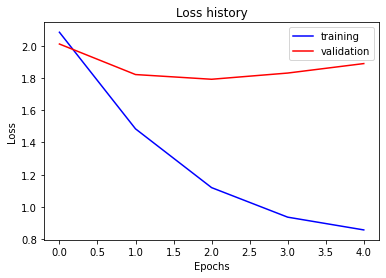

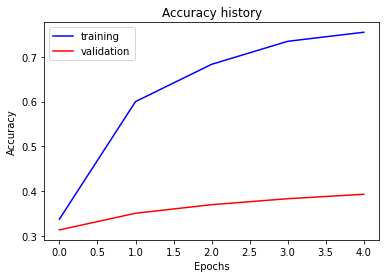

In [ ]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [ ]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

### Save Trained MyResnet18 model

In [ ]:
save_trained_model_weights(my_resnet, out_dir="./")

### Part 3.3 Visualize and Analyze Confusion Matrix

**TODO 17:** Visualize and analyze the confusion matrix.

You'll need to find an example of an image that is misclassified for the report. Use the confusion matrix and the `get_pred_images_for_target` function to help your analysis

In [28]:
from my_resnet import MyResNet18
# loading from colab for confusion matrices
path = "/home/jer/grad/ML/distracted_driver_detection/cnn/trained_model_rn18_74.pt"
my_resnet = MyResNet18()
# model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(my_resnet, map_location=torch.device('cpu'))['state_dict'], strict=False)
# my_resnet.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [29]:
generate_and_plot_confusion_matrix(my_resnet, trainer.val_dataset, use_cuda=is_cuda)

NameError: name 'trainer' is not defined